# Finding Nuisance flood elevations and corresponsding buildings with 'wet feet' in VA Beach

### import needed modules

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import gridspec
from ipywidgets.widgets.interaction import interact, interact_manual

### Define functions needed

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def save_figure(path,name):
    plt.savefig(path+name+".png",
                dpi=200,
                facecolor='white',
                edgecolor='white')
    
def ECDF(dataseries):
    sq = dataseries.value_counts()
    ecdf = sq.sort_index().cumsum()*1/len(dataseries)
    return ecdf

def ECDF_FUNC(value, ecdf, mode='getvalue'):
    #Input probability, return value
    if mode == 'getvalue':
        prob_idx = find_nearest(ecdf,1-value)
        nearest_value = (1-ecdf[prob_idx])
        output = [prob_idx,nearest_value]
        #print('A value of {0:3.3f} corresponds to the given exceedance probability of {1:3.2f}%'.format(output,(1-ecdf[prob_idx])*100))
    elif mode == 'getprob':
        value_idx = find_nearest(ecdf.index,value)
        #print(value_idx)
        output = ecdf[ecdf.index[value_idx]]
        exceed_prob = (1-output)*100
        #print('An exceedance probability of {0:.2f}% corresponds to the given value {1:.3f}'.format(exceed_prob,value))
    else:
        print('INPUT ERROR: "mode" must be "getvalue" or "getprob"')
    return output

In [3]:
def get_exceedance_value(data_file,gauge_correction,MHHW2NAVD88,target_exceedance_prob):
    Data = pd.read_csv(data_file, 
                       delimiter=',',
                       usecols=(0,1,2),
                       infer_datetime_format=True,
                       skiprows=0
                      )
    Data.columns = ['datetime','water_level','ty']
    Data['datetime'] = Data['datetime'].apply(pd.to_datetime)
    Data.set_index('datetime', inplace=True)
    df = Data[Data.ty == 'HH'].append(Data[Data.ty == 'H ']).reset_index().sort_values(by='datetime').set_index('datetime')
    #Data.set_index('ty').ix['H ','HH']
    #raw water_level data in ft above MHHW(0.349m or (34.9cm/(2.54*12(cm/ft))) NAVD @ Sewells Point,VA)
    swel_series = df.water_level['1996-01-01':'2000-12-31']+MHHW2NAVD88 #ft NAVD
    ecdf_swel = ECDF(swel_series)
    swel_val = ECDF_FUNC(target_exceedance_prob,ecdf_swel,mode="getvalue")
    tidegauge_swel_val = swel_val[0]*12*2.54/100+gauge_correction
    print('A value of {0:3.3f} ft NAVD corresponds to the given exceedance probability of {1:3.2f}%'.format(swel_val[0],swel_val[1]*100))
    print('This is equivalent to {0:3.3f} meters referenced to the gauge.'.format(tidegauge_swel_val))

In [4]:
def nuisance_flooding(user_input,lag_ecdf,ffe_ecdf):
    title ='FFE vs LAG'
    #Initialize figure and set dimensions
    fig = plt.figure(figsize = (9,9))
    gs = gridspec.GridSpec(2,2)
    ax1 = fig.add_subplot(gs[:,:])
    ax1.set_title(title,fontsize=20)
    #Remove the plot frame lines. They are unnecessary chartjunk.
    ax1.spines["top"].set_visible(False)  
    ax1.spines["right"].set_visible(False) 
    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax1.get_xaxis().tick_bottom()  
    ax1.get_yaxis().tick_left()  
    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    ax1.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    ax1.set_xlabel("Elevation (ft)", fontsize=16)  
    ax1.set_ylabel("Frequency of occurence", fontsize=16)  
    #set x-axis limits
    ax1.set_xlim(-5,35)
    ax1.set_ylim(0,1)
    #Plot
    ax1.step(lag_ecdf.index,lag_ecdf.values,color='darkorange',linewidth=2)
    ax1.step(ffe_ecdf.index,ffe_ecdf.values,color='purple',linewidth=2)
    #Find %wet vs. %damaged
    SWEL = user_input
    FFE_SWEL = ECDF_FUNC(SWEL, ffe_ecdf, mode="getprob")
    LAG_SWEL = ECDF_FUNC(SWEL, lag_ecdf, mode="getprob")
    x=[SWEL,SWEL]
    y=[FFE_SWEL,LAG_SWEL]
    ax1.vlines(SWEL,0,1,alpha=0.5,color='g',linestyle='dashed',linewidth=2)
    ax1.scatter(x, y, s=50, c='g', alpha=0.9, marker='o')
    print('For a {0:2.2f}ft SWEL, {1:2.3f}% of buildings are wet and {2:2.3f}% of buildings are damaged.'.format(SWEL,LAG_SWEL*100,FFE_SWEL*100))

## Import HAZUS Building Data
Empirical cummulative distributions are then defined to describe the LAG (lowest ajacent grade) elevation and FFE (first floor elevevation) for each building footprint. 

In [8]:
hazus_dir = "/media/sf_Shared_Linux/recurrence_interval"
hazus_dbf = "HAZUS_BM_Data_LynnHaven.dbf"
os.chdir(hazus_dir)
from dataIO import dbf2df, df2dbf
hzsdf = dbf2df(hazus_dbf)
hzsdf.set_index('CensusBloc',inplace=True)
lag_ecdf=ECDF(hzsdf.LAG_ELEV)
ffe_ecdf=ECDF(hzsdf.LAG_ELEV+hzsdf.FFH_RegEq)

In [9]:
hzsdf.T

CensusBloc     518100444021015          518100444012025 518100444021015  \
BM_OBJID                     1                        2               3   
CityPermit               17.33                        0               0   
FFH_RegEq              3.12944                 0.957036       -0.179005   
Final_FFE             0.213266                 0.957036       -0.179005   
HAG_ELEV               17.7943                  16.6426         16.9658   
LAG_ELEV               17.1167                  14.4983         16.2487   
UDF_Addres  1000 GREAT NECK RD  1020 GENERAL JACKSON DR   1201 BAYNE DR   
UDF_FirstF                   0                        1               0   

CensusBloc 518100444021015 518100444021015         518100444021026  \
BM_OBJID                 7               8                      13   
CityPermit               0               0                       0   
FFH_RegEq        -0.417645        0.345496              -0.0964322   
Final_FFE        -0.417645        0.345496              -0.0964322   
HAG_ELEV            17.524         16.9424                 19.7363   
LAG_ELEV           16.6132         15.6293                 18.7782   
UDF_Addres                   1251 BAYNE DR  1181 FIRST COLONIAL RD   
UDF_FirstF               0               0                       0   

CensusBloc         518100444021026         518100444021015  \
BM_OBJID                        14                      15   
CityPermit                       0                       0   
FFH_RegEq                 -0.28701                 1.62534   
Final_FFE                 -0.28701                 1.62534   
HAG_ELEV                   18.8887                 17.3197   
LAG_ELEV                   18.1526                 14.4159   
UDF_Addres  1201 FIRST COLONIAL RD  1301 FIRST COLONIAL RD   
UDF_FirstF                       0                       2   

CensusBloc     518100444021028 518100444021029          ...            \
BM_OBJID                    19              20          ...             
CityPermit                   0               0          ...             
FFH_RegEq              1.26195         1.92335          ...             
Final_FFE              1.26195         1.92335          ...             
HAG_ELEV                 12.42         16.0294          ...             
LAG_ELEV               9.98365         15.1663          ...             
UDF_Addres  1274 GREAT NECK RD                          ...             
UDF_FirstF                   1               2          ...             

CensusBloc          518100446002003    518100442001016  518100446003003  \
BM_OBJID                      26020              38924            43400   
CityPermit                     13.7                  0             10.6   
FFH_RegEq                   8.44292            1.41664          4.11869   
Final_FFE                   11.0647            1.41664           4.3232   
HAG_ELEV                    11.9445             9.5102          10.8849   
LAG_ELEV                    2.63529            7.99447           6.2768   
UDF_Addres  1501 DUKE OF WINDSOR RD  1260 BEAUTIFUL ST  1321 CHEWINK CT   
UDF_FirstF                       11                  1                4   

CensusBloc  518100446003003        518100420001008      518100420001004  \
BM_OBJID              43461                  52360                52983   
CityPermit             8.46                      0                  7.8   
FFH_RegEq           4.65475                2.04281              3.92975   
Final_FFE           5.02964                2.04281             -3.80728   
HAG_ELEV            5.86741                15.4465               15.089   
LAG_ELEV            3.43036                13.1429              11.6073   
UDF_Addres  1329 CHEWINK CT  1476 TRADING POINT LN  3850 LITTLE NECK PT   
UDF_FirstF                5                      2                    4   

CensusBloc   518100412002016    518100412001008   518100454062005  \
BM_OBJID               62157              63147        

## Calculate nuisance flood elevations from NOAA tide gauge data
For convenience 'nuisance' flooding is defined as inundation occuring on an average bi-weekly interval, or 26 events per year. Given that tidal cycles repeat approximately daily this means each day we have a 26 out of 365, or ~7.12%, probability of flooding at this elevation.  

### Sewells Point: 8638610

In [32]:
working_dir = r"/home/user/Documents/recurrence_interval/NOAA_Data/8638610/high_low"
os.chdir(working_dir)  
data_file = '8638610_hl.csv'
gauge_correction       = 1.827 #meters    
target_exceedance_prob = 0.0712
MHHW2NAVD88            = 34.9/(2.54*12)
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,MHHW2NAVD88=MHHW2NAVD88,target_exceedance_prob=target_exceedance_prob)

A value of 2.057 ft NAVD corresponds to the given exceedance probability of 7.11%
This is equivalent to 2.454 meters referenced to the gauge.


With the calculated nuisance flooding elevation (NFE) the percent of all building footprints which are wetted ($LAG < NFE$) and damaged ($NFE > FFE$) can be calculated using the defined empirical CDFs.

For a 3.00ft SWEL, 0.200% of buildings are wet and 0.012% of buildings are damaged.


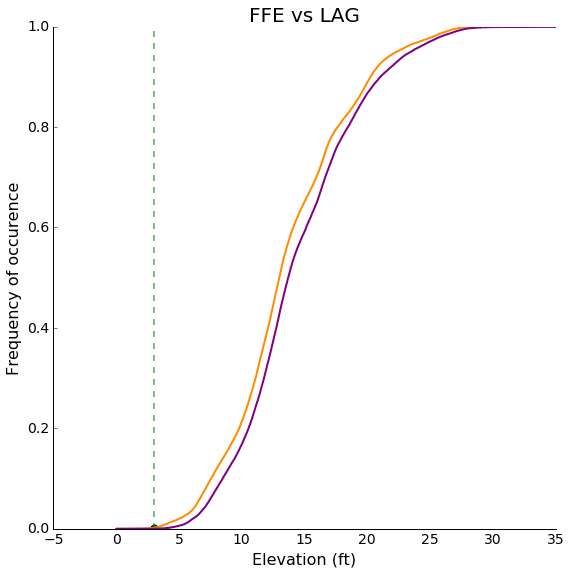

In [10]:
nuisance_flooding(3.0,lag_ecdf,ffe_ecdf)

In [13]:
number_buildings = len(hzsdf)
number_wet_bl = 0.00200*number_buildings
number_damaged_bl = 0.00012*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the baseline scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 76070, this means ~152 are wet and ~9 are damaged in the baseline scenario.


## Future scenarios (+1.5 and +3.0 feet)
Considering what this level of nuisance flooding will mean in the future with added sea level rise can be accomplished by making the that SLR will not affect frequent water level events in a non-linear fashion. This assumption agrees well with what was seen in North Carolina during the XXXX study conducted by Dewberry. With this assumption in place we can then the future nuisance flood elevations simply by adding SLR to the existing NFE. This result in values of 3.557ft and 5.057ft. Plugging these numbers back into the empirical CDFs of the building LAG and FFE data gives the results. 

For a 4.50ft SWEL, 1.466% of buildings are wet and 0.338% of buildings are damaged.


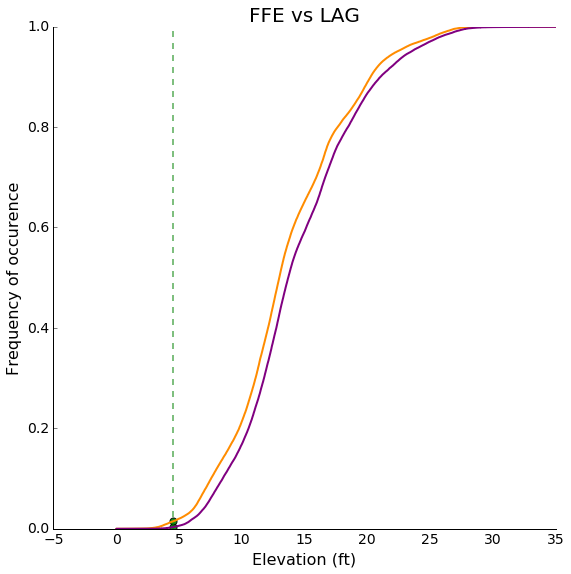

In [11]:
nuisance_flooding(4.5,lag_ecdf,ffe_ecdf)

In [14]:
number_wet_bl = 0.01466*number_buildings
number_damaged_bl = 0.00338*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the 1.5ft SLR scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 76070, this means ~1115 are wet and ~257 are damaged in the 1.5ft SLR scenario.


For a 6.00ft SWEL, 3.602% of buildings are wet and 1.831% of buildings are damaged.


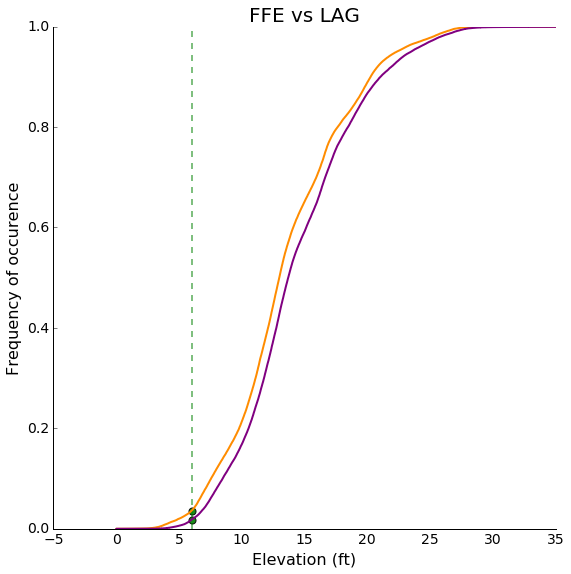

In [12]:
nuisance_flooding(6.0,lag_ecdf,ffe_ecdf)

In [15]:
number_wet_bl = 0.03602*number_buildings
number_damaged_bl = 0.01831*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the 3.0ft SLR scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 76070, this means ~2740 are wet and ~1393 are damaged in the 3.0ft SLR scenario.


### Chesapeake Bay Bridge Tunnel: 8638863

In [30]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8638863/high_low"
os.chdir(working_dir) 
data_file = '8638863_hl.csv'
gauge_correction = 0.0 #meters    
target_exceedance_prob = 0.0712
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

FileNotFoundError: [Errno 2] No such file or directory: '/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8638863/high_low'

### Duck, NC: 8651370

In [12]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8651370/high_low"
os.chdir(working_dir) 
data_file = '8651370_hl.csv'
gauge_correction = 6.330696 #meters    
target_exceedance_prob = 0.07
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

A value of 2.089 ft NAVD corresponds to the given exceedance probability of 7.02%
This is equivalent to 6.967 meters referenced to the gauge.


### Oregon Inlet Marina, NC: 8652587

In [13]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8652587/high_low"
os.chdir(working_dir) 
data_file = '8652587_hl.csv'
gauge_correction = 1.002792 #meters    
target_exceedance_prob = 0.07
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

A value of 1.808 ft NAVD corresponds to the given exceedance probability of 7.04%
This is equivalent to 1.554 meters referenced to the gauge.


## Finding Nuisance Flooding

### Import HAZUS building footprint data

In [ ]:
interact_manual(nuisance_flooding,user_input=[-5,35,0.05])